In [2]:
cd /home/hemanth/cnn-downscaling/src/

/home/hemanth/cnn-downscaling/src


In [3]:
%load_ext autoreload
%autoreload 2

In [15]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap, cm
import seaborn as sns
import zarr

import torch
import torch.nn.functional as F

from training.data import WeatherBenchSuperresolutionDataModule
from training.models import LitSuperresolutionModelWrapper

In [5]:
plt.style.use('seaborn-pastel')
sns.set_style("ticks")

In [150]:
best_ckpt = "/home/hemanth/cnn-downscaling/src/evaluation/cnn-pr-scaled.ckpt"

In [151]:
DATA_DIR = "/home/hemanth/downscale/generative-downscaling/data/processed/temp/"
COARSE_SUB_DIR = "5625/temp_5625_processed.zarr"  # 5.625 degrees
FINE_SUB_DIR = "1406/temp_1406_processed.zarr"  # 1.402 degrees

In [152]:
data_module = WeatherBenchSuperresolutionDataModule(
    coarse_dir = os.path.join(DATA_DIR, COARSE_SUB_DIR),
    fine_dir = os.path.join(DATA_DIR, FINE_SUB_DIR),
    batch_size = 1461  # length of test set
)

data_module.setup(stage=None)

test_dataloader = data_module.test_dataloader()
coarse_test, fine_test = iter(test_dataloader).next()

del test_dataloader

In [153]:
model = LitSuperresolutionModelWrapper.load_from_checkpoint(best_ckpt)
model.eval()

LitSuperresolutionModelWrapper(
  (model): Sequential(
    (0): Conv2d(1, 3, kernel_size=(3, 3), stride=(1, 1), padding=valid)
    (1): ReLU()
    (2): Conv2d(3, 5, kernel_size=(3, 3), stride=(1, 1), padding=valid)
    (3): ReLU()
    (4): Conv2d(5, 13, kernel_size=(3, 3), stride=(1, 1), padding=valid)
    (5): ReLU()
    (6): Conv2d(13, 55, kernel_size=(3, 3), stride=(1, 1), padding=valid)
    (7): ReLU()
    (8): Conv2d(55, 21, kernel_size=(3, 3), stride=(1, 1), padding=valid)
    (9): ReLU()
    (10): Flatten(start_dim=1, end_dim=-1)
    (11): Linear(in_features=1344, out_features=398, bias=True)
    (12): Linear(in_features=398, out_features=4096, bias=True)
    (13): Unflatten(dim=1, unflattened_size=(64, 64))
  )
  (loss): MSELoss()
)

In [154]:
preds_test = model(coarse_test)
preds_test.shape

torch.Size([1461, 64, 64])

In [155]:
torch.set_grad_enabled(False);

In [156]:
train_dates, val_dates, test_dates = data_module.split_date_ranges

In [157]:
test_pdf = pd.DataFrame(
    fine_test.flatten(),
    index=data_module.fine.loc[test_dates[0]:test_dates[-1]].index,
    columns=["temp_true"]
)
test_pdf["temp_pred"] = preds_test.flatten()

In [158]:
pred_demeaned = (preds_test - preds_test.mean(axis=0, keepdims=True))
true_demeaned = (fine_test - fine_test.mean(axis=0, keepdims=True))

'''
pred_demeaned = (preds_test - preds_test.mean(axis=(1,2), keepdims=True))
true_demeaned = (fine_test - fine_test.mean(axis=(1,2), keepdims=True))
'''
daily_corrs = \
    torch.sum(pred_demeaned*true_demeaned,axis=0) / \
    (torch.sqrt(torch.sum(pred_demeaned ** 2,axis=0)) * torch.sqrt(torch.sum(true_demeaned ** 2,axis=0)))

del pred_demeaned, true_demeaned

In [159]:
test_pdf_unscaled = \
    test_pdf.join(data_module.daily_means).join(data_module.daily_std)

test_pdf_unscaled['temp_true'] = \
    test_pdf_unscaled['temp_true'] * test_pdf_unscaled['std'] + \
    test_pdf_unscaled['mean']

test_pdf_unscaled['temp_pred'] = \
    test_pdf_unscaled['temp_pred'] * test_pdf_unscaled['std'] + \
    test_pdf_unscaled['mean']

del test_pdf_unscaled['mean']
del test_pdf_unscaled['std']

In [160]:
def q02(ser):
    return ser.quantile(.02)

def q98(ser):
    return ser.quantile(.98)

test_biases = test_pdf_unscaled.groupby(
    [test_pdf_unscaled.index.get_level_values("date")]
).agg(['mean', q02, q98])

In [161]:
test_biases_lon = test_pdf_unscaled.groupby(
    [test_pdf.index.get_level_values("date").to_period('M'), "lat", "lon"]
).agg(['mean', q02, q98])

In [162]:
test_biases_lon['bias_mean'] = test_biases_lon['temp_true']['mean'] - test_biases_lon['temp_pred']['mean']
test_biases_lon['bias_q02'] = test_biases_lon['temp_true']['q02'] - test_biases_lon['temp_pred']['q02']
test_biases_lon['bias_q98'] = test_biases_lon['temp_true']['q98'] - test_biases_lon['temp_pred']['q98']

In [163]:
shared_line_kwargs = {"alpha": .67, "linestyle": "dashed", "linewidth": 2}
pctiles_extremes = [.02, .05, .1, .5, .9, .95, .98]

In [164]:
latitudes = data_module.fine.index.levels[1].to_series()
longitudes = data_module.fine.index.levels[2].to_series()

m = Basemap(projection='ortho', lat_0=30 ,lon_0=-100, resolution='l')
x, y = m(*np.meshgrid(longitudes-180,latitudes))

# CNN bias mean, 2nd percentile and 98th percentile

In [165]:
bias_mean_map = test_biases_lon.groupby(["lat", "lon"])["bias_mean"].mean()

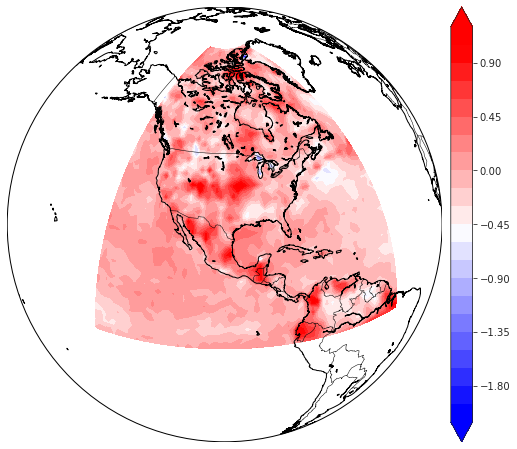

In [166]:
cs = m.contourf(
    x, y,
    bias_mean_map.unstack('lon').values,  # 64 x 64
    levels=24, alpha=1,
    cmap = 'bwr', vmin=-2, vmax=1, extend='both'
)

m.drawcoastlines()
m.drawcountries()

plt.gcf().set_size_inches(16, 8)
m.colorbar();

In [168]:
bias_mean_02_map = test_biases_lon.groupby(["lat", "lon"])["bias_q02"].mean()

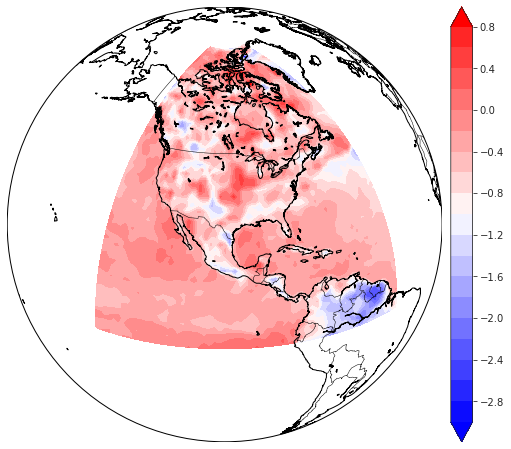

In [169]:
cs = m.contourf(
    x, y,
    bias_mean_02_map.unstack('lon').values,  # 64 x 64
    levels=24, alpha=1,
    cmap = 'bwr', vmin=-3, vmax=1, extend='both'
)

m.drawcoastlines()
m.drawcountries()

plt.gcf().set_size_inches(16, 8)
m.colorbar();

In [170]:
bias_mean_98_map = test_biases_lon.groupby(["lat", "lon"])["bias_q98"].mean()

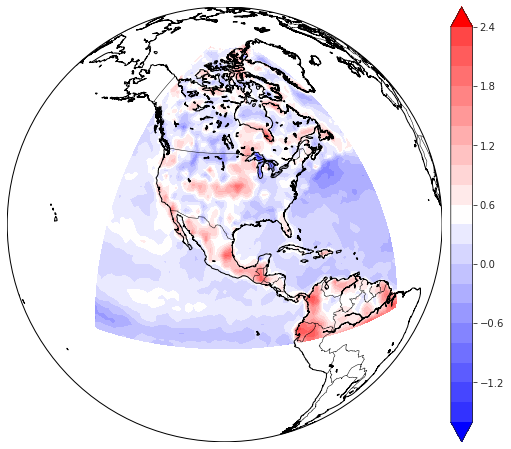

In [180]:
cs = m.contourf(
    x, y,
    bias_mean_98_map.unstack('lon').values,  # 64 x 64
    levels=24, alpha=1,
    cmap = 'bwr', vmin=-2, vmax=3, extend='both'
)

m.drawcoastlines()
m.drawcountries()

plt.gcf().set_size_inches(16, 8)
m.colorbar();

# CNN correlations

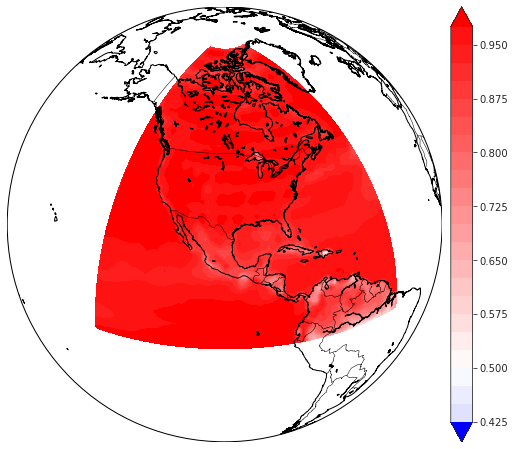

In [88]:
cs = m.contourf(
    x, y,
    daily_corrs,  # 64 x 64
    levels=24, alpha=1,
    cmap = 'bwr', vmin=0, vmax=1, extend='both'
)

m.drawcoastlines()
m.drawcountries()

plt.gcf().set_size_inches(16, 8)
m.colorbar();

# Norm Flows

In [107]:
import zarr 
predictions = zarr.load('/home/hemanth/downscale/generative-downscaling/saved_predictions/Groenke_Final_5epochs/test_hr_pred_epoch04.zarr')
true = zarr.load('/home/hemanth/downscale/generative-downscaling/saved_predictions/Groenke_Final_5epochs/test_hr_true_epoch04.zarr')

In [108]:
print(predictions['t2m'].shape)

(1461, 64, 64)


In [109]:
fine_test = torch.from_numpy(true['t2m'])
predict_test = torch.from_numpy(predictions['t2m'])

In [110]:
test_pdf = pd.DataFrame(
    fine_test.flatten(),
    index=data_module.fine.loc[test_dates[0]:test_dates[-1]].index,
    columns=["temp_true"]
)
test_pdf["temp_pred"] = predict_test.flatten()

In [111]:
pred_demeaned = (preds_test - preds_test.mean(axis=0, keepdims=True))
true_demeaned = (fine_test - fine_test.mean(axis=0, keepdims=True))

daily_corrs_nf = \
    torch.sum(pred_demeaned*true_demeaned,axis=0) / \
    (torch.sqrt(torch.sum(pred_demeaned ** 2,axis=0)) * torch.sqrt(torch.sum(true_demeaned ** 2,axis=0)))

del pred_demeaned, true_demeaned

In [112]:
test_biases_lon_nf = test_pdf.groupby(
    [test_pdf.index.get_level_values("date").to_period('M'), "lat", "lon"]
).agg(['mean', q02, q98])

In [113]:
test_biases_lon_nf['bias_mean'] = test_biases_lon_nf['temp_true']['mean'] - test_biases_lon_nf['temp_pred']['mean']
test_biases_lon_nf['bias_q02'] = test_biases_lon_nf['temp_true']['q02'] - test_biases_lon_nf['temp_pred']['q02']
test_biases_lon_nf['bias_q98'] = test_biases_lon_nf['temp_true']['q98'] - test_biases_lon_nf['temp_pred']['q98']

In [114]:
shared_line_kwargs = {"alpha": .67, "linestyle": "dashed", "linewidth": 2}
pctiles_extremes = [.02, .05, .1, .5, .9, .95, .98]

In [115]:
latitudes = data_module.fine.index.levels[1].to_series()
longitudes = data_module.fine.index.levels[2].to_series()

m = Basemap(projection='ortho', lat_0=30 ,lon_0=-100, resolution='l')
x, y = m(*np.meshgrid(longitudes-180,latitudes))

## Bias mean, 2nd percentile and 98th percentile

In [116]:
bias_mean_map_nf = test_biases_lon_nf.groupby(["lat", "lon"])["bias_mean"].mean()

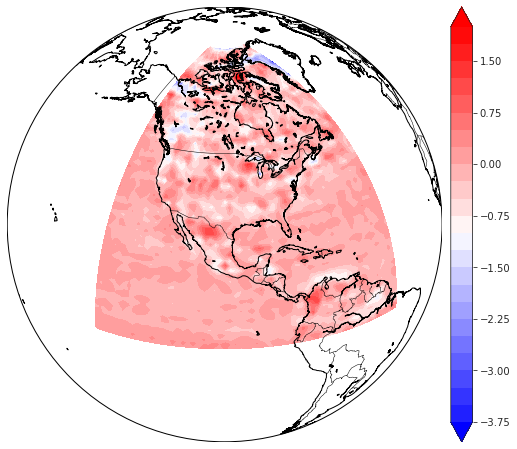

In [147]:
cs = m.contourf(
    x, y,
    bias_mean_map_nf.unstack('lon').values,  # 64 x 64
    levels=24, alpha=1,
    cmap = 'bwr', vmin=-4, vmax=2, extend='both'
)

m.drawcoastlines()
m.drawcountries()

plt.gcf().set_size_inches(16, 8)
m.colorbar();

In [140]:
bias_mean_02_map_nf = test_biases_lon_nf.groupby(["lat", "lon"])["bias_q02"].mean()

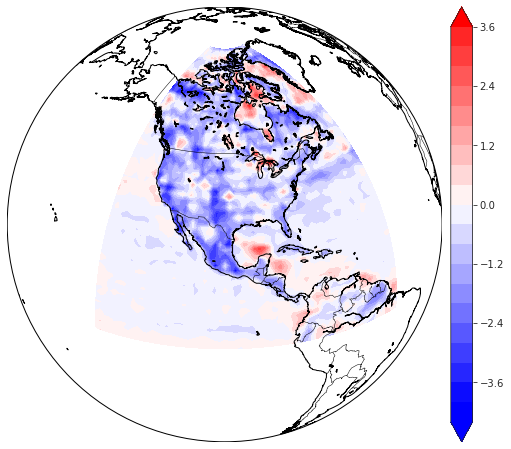

In [141]:
cs = m.contourf(
    x, y,
    bias_mean_02_map_nf.unstack('lon').values,  # 64 x 64
    levels=24, alpha=1,
    cmap = 'bwr', vmin=-4, vmax=4, extend='both'
)

m.drawcoastlines()
m.drawcountries()

plt.gcf().set_size_inches(16, 8)
m.colorbar();

In [181]:
bias_mean_98_map_nf = test_biases_lon_nf.groupby(["lat", "lon"])["bias_q98"].mean()

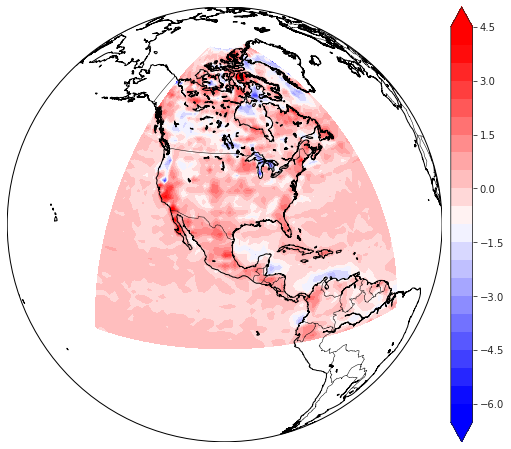

In [183]:
cs = m.contourf(
    x, y,
    bias_mean_98_map_nf.unstack('lon').values,  # 64 x 64
    levels=24, alpha=1,
    cmap = 'bwr', vmin=-6, vmax=4, extend='both'
)

m.drawcoastlines()
m.drawcountries()

plt.gcf().set_size_inches(16, 8)
m.colorbar();

## Correlations

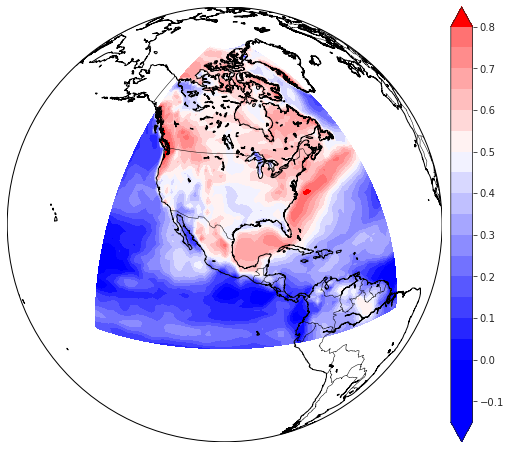

In [122]:
cs = m.contourf(
    x, y,
    daily_corrs_nf,  # 64 x 64
    levels=24, alpha=1,
    cmap = 'bwr', vmin=0, vmax=1, extend='both'
)

m.drawcoastlines()
m.drawcountries()

plt.gcf().set_size_inches(16, 8)
m.colorbar();

# Bilinear Interpolation

In [123]:
true = zarr.load('/home/hemanth/cnn-downscaling/src/evaluation/test_hr_true_bilinearInterpolation.zarr')
predictions = zarr.load('/home/hemanth/cnn-downscaling/src/evaluation/test_hr_pred_bilinearInterpolation.zarr')

In [124]:
fine_test = torch.from_numpy(true['t2m'])
predict_test = torch.from_numpy(predictions['t2m'])

In [125]:
test_pdf = pd.DataFrame(
    fine_test.flatten(),
    index=data_module.fine.loc[test_dates[0]:test_dates[-1]].index,
    columns=["temp_true"]
)
test_pdf["temp_pred"] = predict_test.flatten()

In [126]:
pred_demeaned = (preds_test - preds_test.mean(axis=0, keepdims=True))
true_demeaned = (fine_test - fine_test.mean(axis=0, keepdims=True))

daily_corrs_bl = \
    torch.sum(pred_demeaned*true_demeaned,axis=0) / \
    (torch.sqrt(torch.sum(pred_demeaned ** 2,axis=0)) * torch.sqrt(torch.sum(true_demeaned ** 2,axis=0)))

del pred_demeaned, true_demeaned

In [127]:
test_biases_lon_bl = test_pdf.groupby(
    [test_pdf.index.get_level_values("date").to_period('M'), "lat", "lon"]
).agg(['mean', q02, q98])

In [128]:
test_biases_lon_bl['bias_mean'] = test_biases_lon_bl['temp_true']['mean'] - test_biases_lon_bl['temp_pred']['mean']
test_biases_lon_bl['bias_q02'] = test_biases_lon_bl['temp_true']['q02'] - test_biases_lon_bl['temp_pred']['q02']
test_biases_lon_bl['bias_q98'] = test_biases_lon_bl['temp_true']['q98'] - test_biases_lon_bl['temp_pred']['q98']

In [129]:
shared_line_kwargs = {"alpha": .67, "linestyle": "dashed", "linewidth": 2}
pctiles_extremes = [.02, .05, .1, .5, .9, .95, .98]

In [130]:
latitudes = data_module.fine.index.levels[1].to_series()
longitudes = data_module.fine.index.levels[2].to_series()

m = Basemap(projection='ortho', lat_0=30 ,lon_0=-100, resolution='l')
x, y = m(*np.meshgrid(longitudes-180,latitudes))

## Bias mean, 2nd percentile and 98th percentile

In [173]:
bias_mean_map_bl = test_biases_lon_bl.groupby(["lat", "lon"])["bias_mean"].mean()

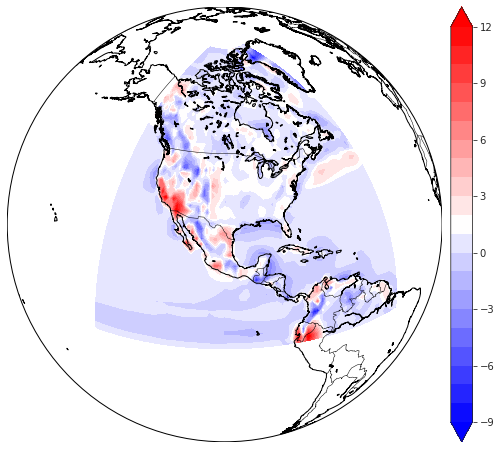

In [174]:
cs = m.contourf(
    x, y,
    bias_mean_map_bl.unstack('lon').values,  # 64 x 64
    levels=24, alpha=1,
    cmap = 'bwr', vmin=-9, vmax=12, extend='both'
)

m.drawcoastlines()
m.drawcountries()

plt.gcf().set_size_inches(16, 8)

m.colorbar();

In [175]:
bias_mean_02_map_bl = test_biases_lon_bl.groupby(["lat", "lon"])["bias_q02"].mean()

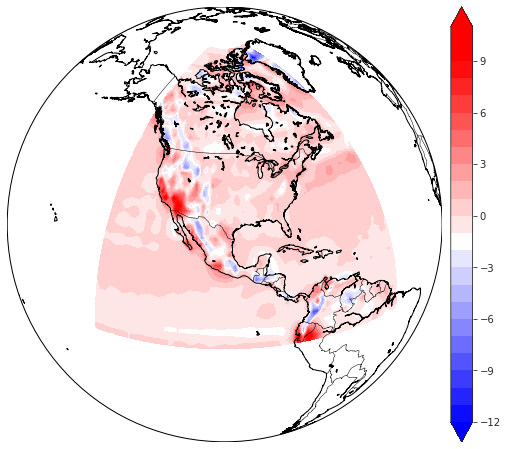

In [176]:
cs = m.contourf(
    x, y,
    bias_mean_02_map_bl.unstack('lon').values,  # 64 x 64
    levels=24, alpha=1,
    cmap = 'bwr', vmin=-12, vmax=9, extend='both'
)

m.drawcoastlines()
m.drawcountries()

plt.gcf().set_size_inches(16, 8)
m.colorbar();

In [177]:
bias_mean_98_map_bl = test_biases_lon_bl.groupby(["lat", "lon"])["bias_q98"].mean()

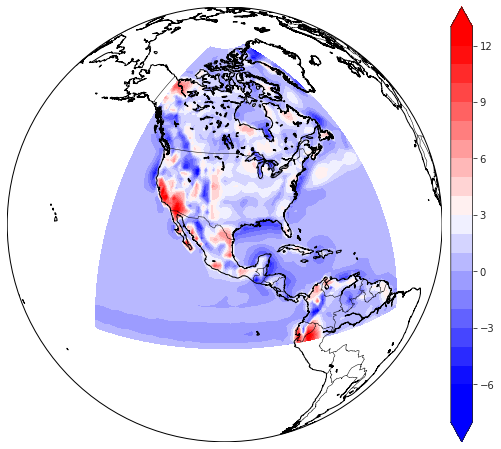

In [178]:
cs = m.contourf(
    x, y,
    bias_mean_98_map_bl.unstack('lon').values,  # 64 x 64
    levels=24, alpha=1,
    cmap = 'bwr', vmin=-6, vmax=12, extend='both'
)

m.drawcoastlines()
m.drawcountries()

plt.gcf().set_size_inches(16, 8)
m.colorbar();

## Correlation

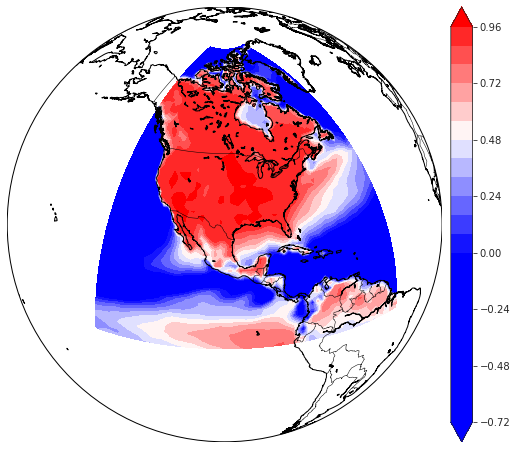

In [179]:
cs = m.contourf(
    x, y,
    daily_corrs_bl,  # 64 x 64
    levels=24, alpha=1,
    cmap = 'bwr', vmin=0, vmax=1, extend='both'
)

m.drawcoastlines()
m.drawcountries()

plt.gcf().set_size_inches(16, 8)

m.colorbar();